# Red neuronal totalmente conectada para clasificación de dígitos en MNIST con comparación del efecto de añadir canales de ruido aleatorio frente a canales de ceros en el rendimiento de validación
### *Universidad Nacional Autónoma de México*
## Autor: **Sebastián González Juárez**

### Idea del código

El código carga el dataset **MNIST**, aplana y normaliza las imágenes, y genera dos variantes del conjunto de entrenamiento:

- **Con canales de ruido**: se añade un vector aleatorio de 784 valores a cada imagen.
- **Con canales de ceros**: se añade un vector de 784 ceros a cada imagen.

Luego, se entrena una red neuronal sencilla con arquitectura:

- Capa densa de 512 neuronas con activación ReLU.
- Capa de salida de 10 neuronas con activación softmax.

El entrenamiento se realiza dos veces (una por cada dataset modificado) y se registra la **exactitud en validación** durante 10 épocas.  
Finalmente, se grafican ambas curvas para comparar el efecto de los canales adicionales (ruido vs ceros) en el rendimiento del modelo.

Importaciones:

In [2]:
import torch
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

Cargar MNIST (train):

In [3]:
mnist_train = datasets.MNIST(root="/content/data", train=True, download=True)
train_images = mnist_train.data.view(60000, 28 * 28).to(torch.float32) / 255.0
train_labels = mnist_train.targets

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]


Canales extra:

In [4]:
N = train_images.size(0)
train_images_with_noise_channels = torch.cat([train_images, torch.rand((N, 784))], dim=1)
train_images_with_zeros_channels = torch.cat([train_images, torch.zeros((N, 784))], dim=1)

Emular validation_split=0.2 de Keras (último 20%):

In [5]:
val_size = int(0.2 * N)
x_train_noise, x_val_noise = train_images_with_noise_channels[:-val_size], train_images_with_noise_channels[-val_size:]
x_train_zeros, x_val_zeros = train_images_with_zeros_channels[:-val_size], train_images_with_zeros_channels[-val_size:]
y_train, y_val = train_labels[:-val_size], train_labels[-val_size:]

DataLoaders:

In [6]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 128
train_loader_noise = DataLoader(TensorDataset(x_train_noise, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader_noise   = DataLoader(TensorDataset(x_val_noise,   y_val),   batch_size=BATCH_SIZE, shuffle=False)
train_loader_zeros = DataLoader(TensorDataset(x_train_zeros, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader_zeros   = DataLoader(TensorDataset(x_val_zeros,   y_val),   batch_size=BATCH_SIZE, shuffle=False)

Modelo (Dense 512 → 10)

In [8]:
import torch.nn as nn
def get_model():
    return nn.Sequential(
        nn.Linear(1568, 512),
        nn.ReLU(),
        nn.Linear(512, 10)  # sin Softmax: CrossEntropyLoss lo aplica internamente
    )
def train_and_validate(train_loader, val_loader, epochs=10):
    model = get_model()
    opt = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    val_acc_hist = []
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc_hist.append(correct / total)
    return model, val_acc_hist

Entrenamientos (ruido y ceros):

In [9]:
_, val_acc_noise = train_and_validate(train_loader_noise, val_loader_noise, epochs=10)
_, val_acc_zeros = train_and_validate(train_loader_zeros, val_loader_zeros, epochs=10)

Gráfica:

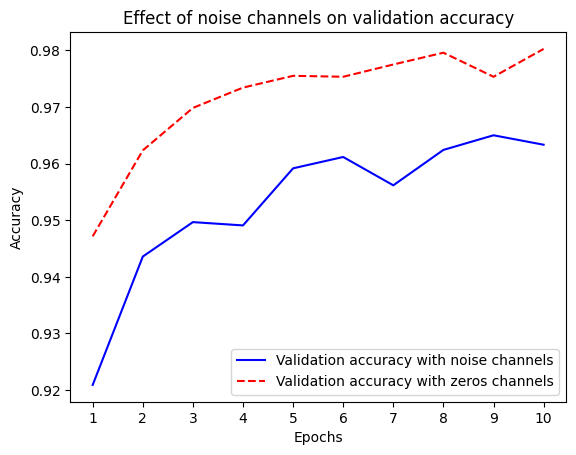

In [10]:
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-", label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "r--", label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.xticks(list(epochs))
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Interpretación de los resultados

La gráfica muestra el efecto de añadir canales adicionales a las imágenes de MNIST:

- **Con ruido (curva azul):** la exactitud de validación es más baja, porque el modelo recibe información irrelevante que actúa como distracción y dificulta el aprendizaje.
- **Con ceros (curva roja):** la exactitud de validación es mayor, ya que los canales de ceros no aportan información, por lo que el modelo los ignora y se entrena casi igual que con los datos originales.

**Conclusión:** añadir canales de ruido perjudica el rendimiento, mientras que añadir canales de ceros no afecta de manera significativa.

### Notas:

Los canales no se sobreponen a la imagen original como una “capa extra de píxeles”, sino que se añaden aparte, al final del vector de características.

* Una imagen MNIST de 28×28 → se aplana a un vector de 784 valores.

* Después, concatenamos otro vector de 784 (ya sea ruido o ceros).

* Resultado: cada muestra deja de ser un vector de 784 y pasa a ser de 1568 valores.

[784 píxeles originales]  +  [784 extras (ruido o ceros)]

Por lo tanto, el modelo está recibiendo un vector extendido de entrada, no una imagen multicanal tipo “RGB”.

Por ejemplo:

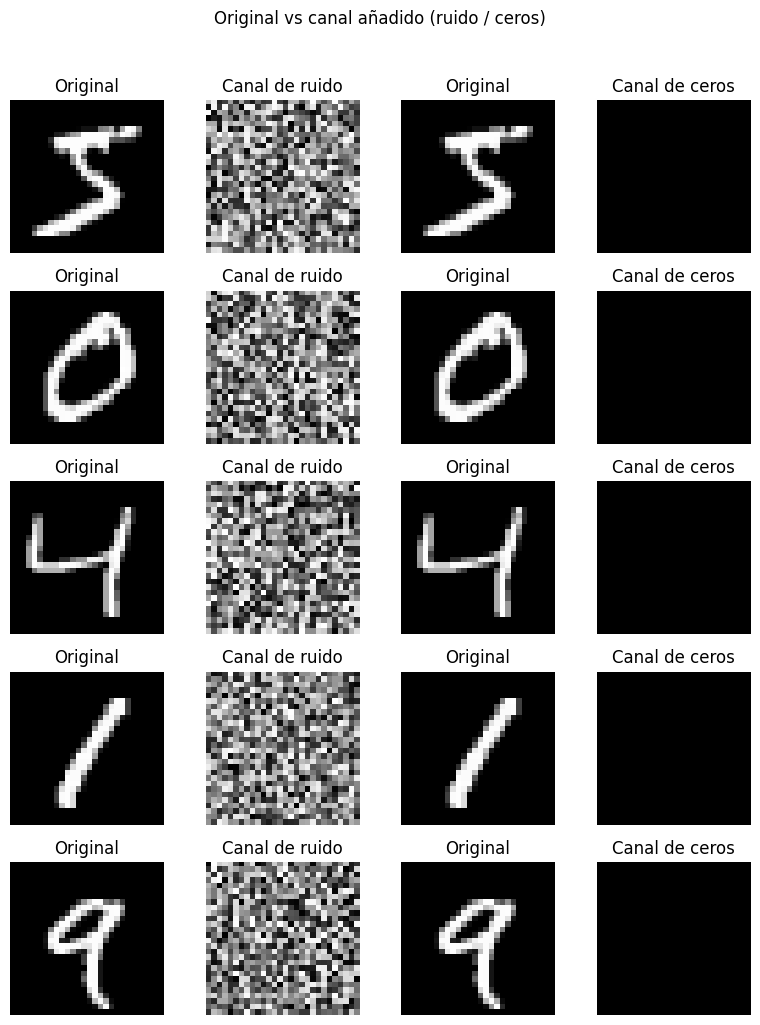

In [11]:
orig_imgs  = train_images_with_noise_channels[:, :784].reshape(-1, 28, 28)
noise_imgs = train_images_with_noise_channels[:, 784:].reshape(-1, 28, 28)

zeros_orig = train_images_with_zeros_channels[:, :784].reshape(-1, 28, 28)
zeros_imgs = train_images_with_zeros_channels[:, 784:].reshape(-1, 28, 28)

# Visualizar algunos índices
indices = [0, 1, 2, 3, 4]
n = len(indices)

fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(8, 2*n))
fig.suptitle("Original vs canal añadido (ruido / ceros)", y=1.02)

for r, i in enumerate(indices):
    # Bloque ruido
    axes[r, 0].imshow(orig_imgs[i].cpu().numpy(), cmap="gray")
    axes[r, 0].set_title("Original")
    axes[r, 0].axis("off")

    axes[r, 1].imshow(noise_imgs[i].cpu().numpy(), cmap="gray")
    axes[r, 1].set_title("Canal de ruido")
    axes[r, 1].axis("off")

    # Bloque ceros
    axes[r, 2].imshow(zeros_orig[i].cpu().numpy(), cmap="gray")
    axes[r, 2].set_title("Original")
    axes[r, 2].axis("off")

    axes[r, 3].imshow(zeros_imgs[i].cpu().numpy(), cmap="gray")
    axes[r, 3].set_title("Canal de ceros")
    axes[r, 3].axis("off")

plt.tight_layout()
plt.show()
